In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from sklearn import metrics
import pickle
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [6]:
color_map = {
    0: [0, 0, 0],  # Background (unlabeled - black)
    1: [255, 0, 0],  # Class 1 (building - #FF0000)
    2: [255, 105, 180],  # Class 2 (water - #FF69B4 )
    3: [65, 117, 5],  # Class 3 (tree - #417505)
    4: [126, 211, 33],  # Class 4 (grass - #7ED321)
    5: [169, 169, 169],  # Class 5 (road - #A9A9A9)
    6: [139, 87, 42]  # Class 6 (soil - #8B572A)
}

In [2]:
image_directory = "../dataset/256_patches/images"
image_dataset = []
for directory_path in os.listdir(image_directory):
    image = cv2.imread(image_directory + "/" + directory_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_dataset.append(image)
image_dataset = np.array(image_dataset)
print(image_dataset.shape)

(120, 256, 256, 3)


In [3]:
mask_directory = "../dataset/256_patches/masks"
mask_dataset = []
for directory_path in os.listdir(mask_directory):
    mask = cv2.imread(mask_directory + "/" + directory_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask_dataset.append(mask)
mask_dataset = np.array(mask_dataset)
print(mask_dataset.shape)

(120, 256, 256)


In [4]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in VGG_model.layers:
    layer.trainable = False
VGG_model.summary()
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [5]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu


def convert_to_chromatic_R(image):
    image = image.astype(np.float32)
    green = image[:, :, 1]
    red = image[:, :, 0]
    blue = image[:, :, 2]
    all = red + green + blue
    return np.divide(red, all, out=np.zeros_like(red), where=all != 0)


def convert_to_chromatic_G(image):
    image = image.astype(np.float32)
    green = image[:, :, 1]
    red = image[:, :, 0]
    blue = image[:, :, 2]
    all = red + green + blue
    return np.divide(green, all, out=np.zeros_like(green), where=all != 0)


def convert_to_chromatic_B(image):
    image = image.astype(np.float32)
    green = image[:, :, 1]
    red = image[:, :, 0]
    blue = image[:, :, 2]
    all = red + green + blue
    return np.divide(blue, all, out=np.zeros_like(blue), where=all != 0)


def convert_to_gli(image):
    image = image.astype(np.float32)
    green = image[:, :, 1]
    red = image[:, :, 0]
    blue = image[:, :, 2]
    s1 = 2 * green - red - blue
    s2 = 2 * green + red + blue
    return np.divide(s1, s2, out=np.zeros_like(s1), where=s2 != 0)


def convert_to_ngrdi(image):
    image = image.astype(np.float32)
    green = image[:, :, 1]
    red = image[:, :, 0]
    s1 = green - red
    s2 = green + red
    return np.divide(s1, s2, out=np.zeros_like(s1), where=s2 != 0)


def apply_otsu_threshold(thresh):
    # Apply Otsu thresholding
    threshold_value = threshold_otsu(thresh)
    binary_image = thresh > threshold_value

    return binary_image


def feature_extraction(image):
    img = np.expand_dims(image, axis=0)
    features_VGG = new_model.predict(img)
    features = pd.DataFrame(features_VGG.reshape(-1, features_VGG.shape[3]))
    features["Chromatic_R"] = apply_otsu_threshold(convert_to_chromatic_R(image)).reshape(-1)
    features["Chromatic_G"] = apply_otsu_threshold(convert_to_chromatic_G(image)).reshape(-1)
    features["Chromatic_B"] = apply_otsu_threshold(convert_to_chromatic_B(image)).reshape(-1)
    features["GLI"] = apply_otsu_threshold(convert_to_gli(image)).reshape(-1)
    features["NGRDI"] = apply_otsu_threshold(convert_to_ngrdi(image)).reshape(-1)
    features.columns = features.columns.astype("str")
    return features

In [40]:
features = pd.DataFrame()
for image in image_dataset:
    features = pd.concat([features, feature_extraction(image)])
print(features.shape)

1/1 [==============================] - 0s 41ms/step
(7864320, 69)


In [41]:
X = features
Y = mask_dataset.reshape(-1)
dataset = pd.DataFrame(X)
dataset["Label"] = Y
dataset = dataset[dataset["Label"] != 0]
X_model = dataset.drop(labels=["Label"], axis=1)
Y_model = dataset['Label']
print(dataset["Label"].unique())
print(dataset["Label"].value_counts())

[1 5 3 6 4 2]
Label
1    1470787
5     869748
3     846604
4     774813
6     156784
2      46828
Name: count, dtype: int64


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_model = le.fit_transform(Y_model)
X_hold, X_test, Y_hold, Y_test = train_test_split(X_model, Y_model, test_size=0.2, random_state=0, stratify=Y_model)
X_train, X_val, Y_train, Y_val = train_test_split(X_hold, Y_hold, test_size=0.2, random_state=0, stratify=Y_hold)

In [43]:
# from sklearn.model_selection import validation_curve
# 
# parameter_range = np.arange(3, 10, 1)
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 5-fold cross validation
# train_score, val_score = validation_curve(xgb.XGBClassifier(random_state=42), X_hold, Y_hold,
#                                           param_name="max_depth",
#                                           param_range=parameter_range,
#                                           cv=4, scoring="accuracy")
# 
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
# 
# mean_val_score = np.mean(val_score, axis=1)
# std_val_score = np.std(val_score, axis=1)
# 
# plt.plot(parameter_range, mean_train_score,
#          label="Training Score", color='b')
# plt.plot(parameter_range, mean_val_score,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Validation Curve with Gradient Boosting")
# plt.xlabel("Max depth")
# plt.ylabel("Accuracy")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [44]:
# from sklearn.model_selection import GridSearchCV
# 
# param_grid = {
#     'n_estimators': [10],
#     'max_depth': [6, 8, 10],
#     'min_child_weight': [4, 6, 8, 10]
# }
# CV = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42), param_grid=param_grid)
# CV.fit(X_train, Y_train)
# print(CV.best_params_)

In [45]:
# from sklearn.model_selection import learning_curve
# 
# sizes, training_scores, testing_scores = learning_curve(
#     xgb.XGBClassifier(random_state=42), X_model, Y_model, cv=5, scoring='accuracy',
#     train_sizes=np.linspace(0.1, 1.0, 10))
# 
# # Mean and Standard Deviation of training scores 
# mean_training = np.mean(training_scores, axis=1)
# Standard_Deviation_training = np.std(training_scores, axis=1)
# 
# # Mean and Standard Deviation of testing scores 
# mean_testing = np.mean(testing_scores, axis=1)
# Standard_Deviation_testing = np.std(testing_scores, axis=1)
# 
# # dotted blue line is for training scores and green line is for cross-validation score 
# plt.plot(sizes, mean_training, '--', color="b", label="Training score")
# plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
# 
# # Drawing plot 
# plt.title("LEARNING CURVE FOR Gradient Boosting")
# plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
# plt.tight_layout()
# plt.show()

In [46]:
start = time.time()
model = xgb.XGBClassifier(max_depth=6, random_state=42)
print("Start training...")
model.fit(X_train, Y_train)
end = time.time()
print("Time execution : ", end - start)
pickle.dump(model, open('../models/XGB', 'wb'))

Start training...
Time execution :  276.5264856815338


In [7]:
loaded_model = pickle.load(open('../models/XGB', 'rb'))

In [48]:
from sklearn.metrics import mean_absolute_error

pred_val = loaded_model.predict(X_val)
pred_train = loaded_model.predict(X_train)
val_accuracy = metrics.accuracy_score(Y_val, pred_val)
train_accuracy = metrics.accuracy_score(Y_train, pred_train)
print("Validation accuracy=", val_accuracy)
print("Train accuracy =", train_accuracy)
val_error = mean_absolute_error(pred_val, Y_val)
train_error = mean_absolute_error(pred_train, Y_train)
print("Validation error=", val_error)
print("Train error =", train_error)

Validation accuracy= 0.8676246190871295
Train accuracy = 0.8714549355579229
Validation error= 0.3284080355173588
Train error = 0.31964620624465484


Balanced accuracy = 0.835106461432297
Test asccuracy = 0.8678222522034826
Mean IOU = 0.7686303387375436
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    294157
           1       0.93      0.82      0.87      9365
           2       0.86      0.87      0.87    169321
           3       0.84      0.85      0.85    154963
           4       0.82      0.85      0.83    173950
           5       0.80      0.72      0.76     31357

    accuracy                           0.87    833113
   macro avg       0.86      0.84      0.85    833113
weighted avg       0.87      0.87      0.87    833113


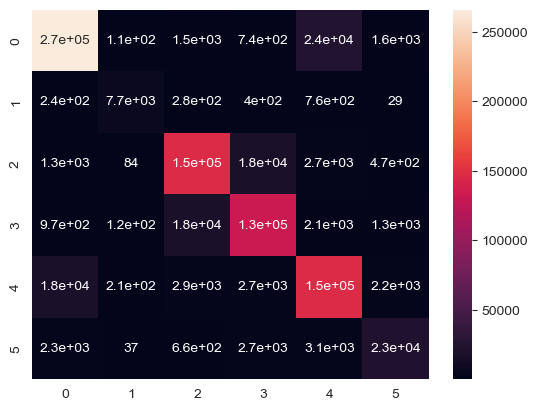

In [49]:
import seaborn as sns

# Make predictions on the test set
prediction_test = loaded_model.predict(X_test)
# Calculate and print the evaluations
balanced_accuracy = metrics.balanced_accuracy_score(Y_test, prediction_test)
accuracy = metrics.accuracy_score(Y_test, prediction_test)
iou = metrics.jaccard_score(Y_test, prediction_test, average='weighted')
print("Balanced accuracy =", balanced_accuracy)
print("Test asccuracy =", accuracy)
print("Mean IOU =", iou)
sns.heatmap(metrics.confusion_matrix(Y_test, prediction_test, labels=[0, 1, 2, 3, 4, 5]), annot=True)
print(metrics.classification_report(Y_test, prediction_test, labels=[0, 1, 2, 3, 4, 5]))

In [50]:
image_directory3 = "../dataset/256_patches_splitted/test/images"
for subdir in os.listdir(image_directory3):
    print("Predict image : " + subdir)
    img = cv2.imread(image_directory3 + "/" + subdir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = loaded_model.predict(feature_extraction(img))
    segmented_result = result.reshape((256, 256, 1))
    segmented_result = cv2.convertScaleAbs(segmented_result)
    cv2.imwrite('../results/XGB/' + subdir, segmented_result)

Predict image : image_patch_11.tif
1/1 [==============================] - 0s 187ms/step
Predict image : image_patch_17.tif
1/1 [==============================] - 0s 62ms/step
Predict image : image_patch_210.tif
1/1 [==============================] - 0s 55ms/step
Predict image : image_patch_311.tif
1/1 [==============================] - 0s 57ms/step
Predict image : image_patch_34.tif
1/1 [==============================] - 0s 52ms/step
Predict image : image_patch_38.tif
1/1 [==============================] - 0s 54ms/step
Predict image : image_patch_41.tif
1/1 [==============================] - 0s 52ms/step
Predict image : image_patch_410.tif
1/1 [==============================] - 0s 51ms/step
Predict image : image_patch_56.tif
1/1 [==============================] - 0s 51ms/step
Predict image : image_patch_61.tif
1/1 [==============================] - 0s 50ms/step
Predict image : image_patch_610.tif
1/1 [==============================] - 0s 51ms/step
Predict image : image_patch_65.tif
1/1

[1 2 3 4 5 6]


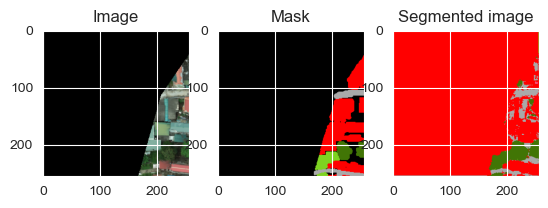

[1 2 3 4 5 6]


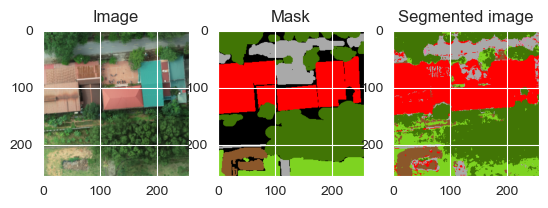

[1 2 3 4 5 6]


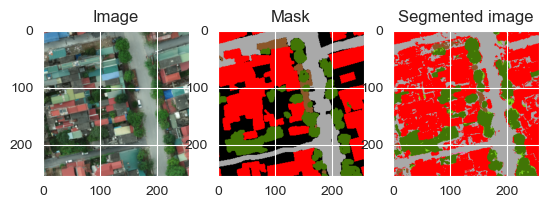

[1 3 4 5 6]


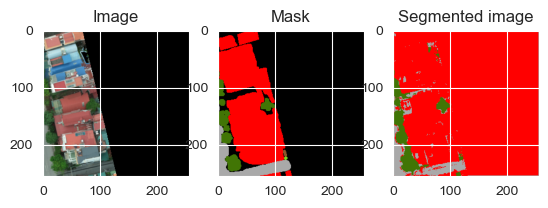

[1 2 3 4 5 6]


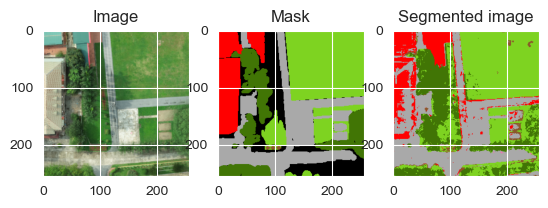

[1 2 3 4 5 6]


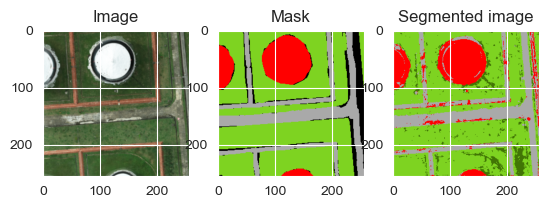

[1 2 3 4 5 6]


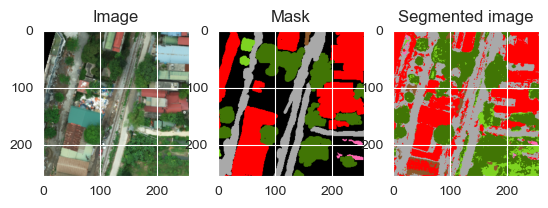

[1 2 3 4 5 6]


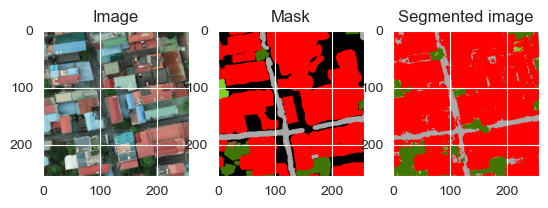

[1 2 3 4 5 6]


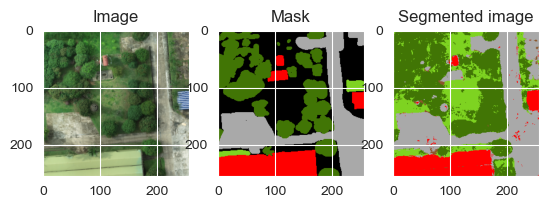

[1 2 3 4 5 6]


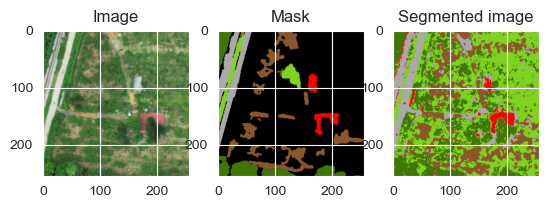

[1 2 3 4 5 6]


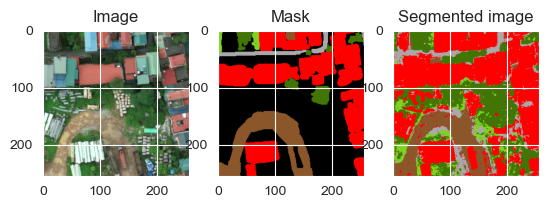

[1 2 3 4 5 6]


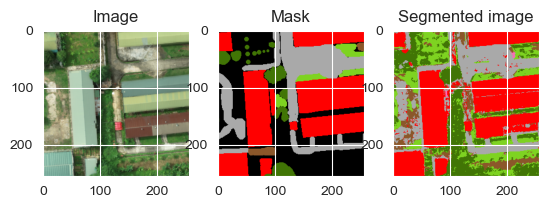

[1 2 3 4 5 6]


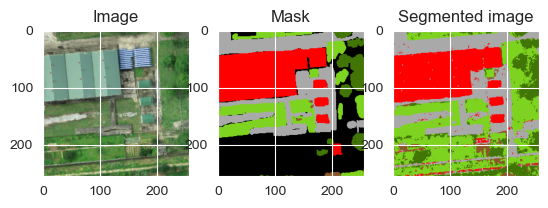

[1 3 4 5 6]


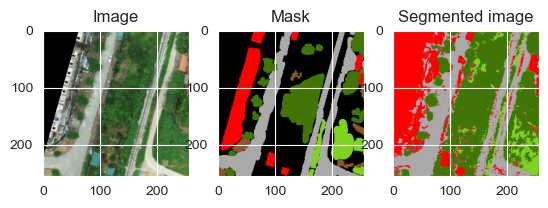

[1 2 3 4 5 6]


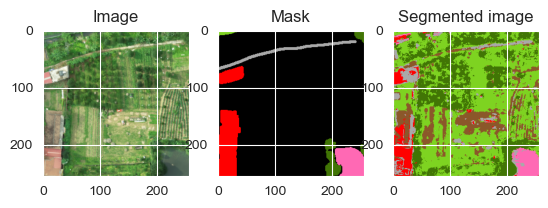

[1 2 3 4 5 6]


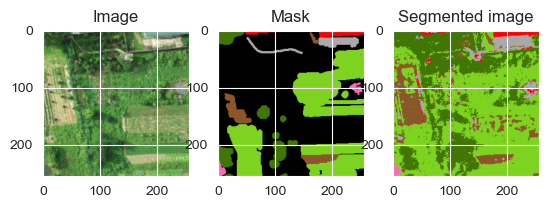

[1 2 3 4 5 6]


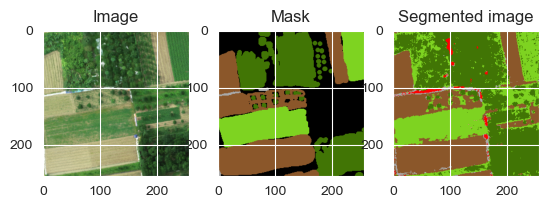

[1 2 3 4 5 6]


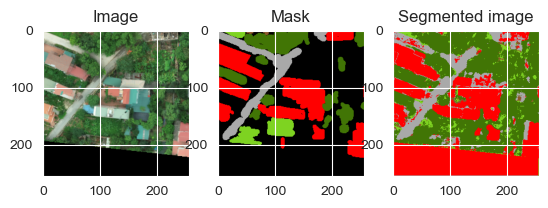

[1 2 3 4 5 6]


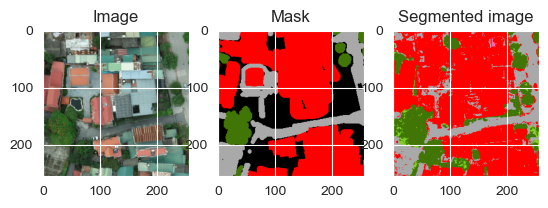

[1 2 3 4 5 6]


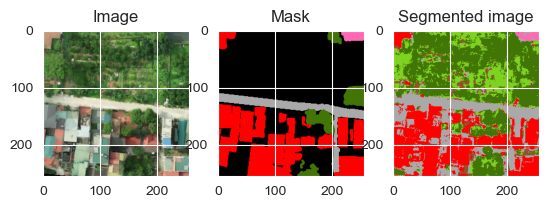

[1 2 3 4 5 6]


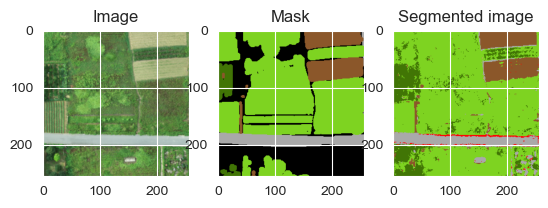

[1 2 3 4 5 6]


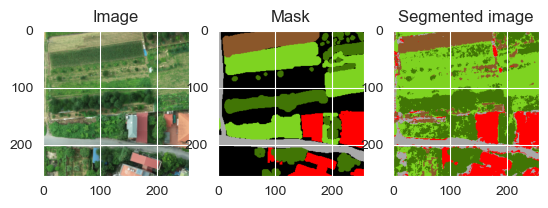

[1 2 3 4 5 6]


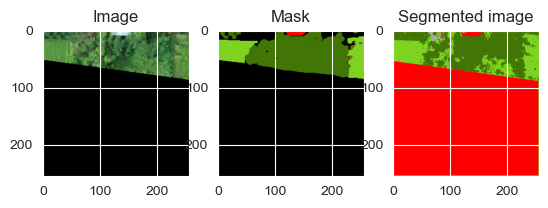

[1 2 3 4 5 6]


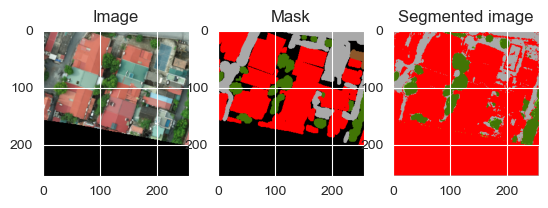

In [51]:
# test_img = cv2.imread("../dataset/256_patches_splitted/train/images/image_patch_15.tif")
# features = feature_extraction(test_img, "image")
# result = loaded_model.predict(features)
# segmented_result = result.reshape((256, 256, 1))
# print("Here  : ", np.unique(segmented_result))
# cv2.imwrite('../results/RF_test_1.tif', segmented_result)
image_directory = "../dataset/256_patches_splitted/test/images"
test_directory = "../dataset/256_patches_splitted/test/masks"
for subdir in os.listdir(test_directory):
    result_dir = "image" + subdir[4:]
    image = cv2.imread(image_directory + "/" + result_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(test_directory + "/" + subdir)
    result = cv2.imread("../results/XGB/" + result_dir, 0)
    print(np.unique(result)+1)
    result = cv2.merge([result, result, result])
    rgb_result = np.zeros(result.shape, dtype=np.uint8)
    for i in range(0, 6):
        rgb_result[np.all(result == [i, i, i], axis=-1)] = color_map[i+1]
    for i in range(0, 7):
        mask[np.all(mask == [i, i, i], axis=-1)] = color_map[i]
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask)
    plt.subplot(1, 3, 3)
    plt.title("Segmented image")
    plt.imshow(rgb_result)
    plt.show()

1/1 [==============================] - 0s 41ms/step


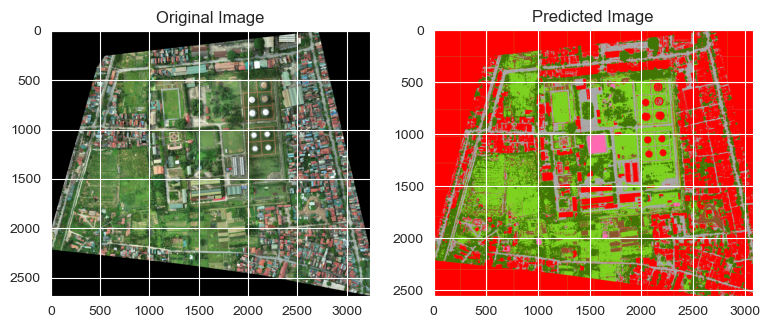

In [10]:
from smooth_blending import predict_img_with_smooth_windowing
from sklearn.preprocessing import MinMaxScaler
from patchify import patchify, unpatchify
from PIL import Image

scaler = MinMaxScaler()

patch_size = 256
file_path = "../scenes/01.Khoxang_H6/1_transparent_mosaic_group1_resample_03m.tif"
large_image = cv2.imread(file_path)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
SIZE_X = (large_image.shape[1] // patch_size) * patch_size  #Nearest size divisible by our patch size
SIZE_Y = (large_image.shape[0] // patch_size) * patch_size  #Nearest size divisible by our patch size
large_image = Image.fromarray(large_image)
input_img = large_image.crop((0, 0, SIZE_X, SIZE_Y))
input_img = np.array(input_img)
patches_img = patchify(input_img, (patch_size, patch_size, 3),
                       step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:, :, 0, :, :, :]

patched_prediction = []

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        pred = loaded_model.predict(feature_extraction(single_patch_img))
        pred = pred.reshape((256, 256, 1))
        pred = cv2.convertScaleAbs(pred)
        patched_prediction.append(pred)
patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1],
                                                     patches_img.shape[2], patches_img.shape[3]])
predicted_image = unpatchify(patched_prediction, (input_img.shape[0], input_img.shape[1]))
cv2.imwrite("../results/xgb.tif", predicted_image)
predicted_image = cv2.merge([predicted_image, predicted_image, predicted_image])
for i in range(0, 6):
    predicted_image[np.all(predicted_image == [i, i, i], axis=-1)] = color_map[i+1]
plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(large_image)
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()